How to estimate noise in High-Frequency radar radial measurements
===================

This tutuorial shows how to estimate noise from High-Freuency data. It reproduces the calculations and figures of the paper:

* Jordi Isern-Fontanet, Lucía Quirós-Collazos, Jordi Iglesias, Justino. Martínez, Joaquim Ballabrera-Poy, Jaume García-Theatre, Cristina González-Haro and Emili García-Ladona (2026). **Data-Driven Noise Estimation for Individual High-Frequency Radar Stations**. Submitted to *J. Atmos. Oceanic Technol.*

This turtorial uses the dataset:

* Lucía Quirós-Collazos, Jordi Isern-Fontanet, Jordi Iglesias, Justino. Martínez, Joaquim Ballabrera-Poy, Jaume García-Theatre, Cristina González-Haro and Emili García-Ladona (2025). **Radial velocities for noise estimation of ICATMAR HF radar stations (v1.0)** https://doi.org/10.20350/digitalCSIC/17704

In [1]:
# System modules

import os
import glob
import sys

# Import scientific modules

import numpy as np
import xarray as xr

# Graphical packages

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS

# Import the toosl for estimating noise

# Add the path to the package if it is not already in PYTHONPATH

sys.path.append(os.sep.join(os.getcwd().split(os.sep)[:-1]) + os.sep)
from hfradar import get_hfr_noise

# Each time a module is modified it is releaded

%load_ext autoreload
%autoreload 2

# Inline ploting

%matplotlib inline

# Parameters

Set the parameters necessary to run the notebook. Download the data set from https://doi.org/10.20350/digitalCSIC/17704 and modify `datapath` accordingly.

In [2]:
datapath = '/Users/jisern/Recerca/Data/Radar/L2B/'

Graphical parmeters

In [3]:
width = 4
height = 4

Graphical information and objects

In [4]:
# Default color cycle

refcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Land mask for maps

land = NaturalEarthFeature(category='physical',
                           name='land',
                           scale='10m',
                           facecolor=COLORS['land'])
# Ocean mask for maps

ocean = NaturalEarthFeature(category='physical',
                            name='ocean',
                            scale='10m',
                            facecolor=COLORS['water'])

# Load and prepare the data

Load the data

In [5]:
hfrdata = {}              # Radar data

print('Loading data:')

for file in glob.glob(datapath + 'RDLm_????_*l2b.nc'):

    # Get the station name

    print('--', file)

    # Read the data

    ds = xr.open_dataset(file, engine="netcdf4")

    # Get information about the stations

    site = ds.attrs['Site'][:4]

    res = ds.attrs['Origin'].split(' ')
    lat0 = float(res[0])
    lon0 = float(res[-1])
    
    # Input files only has lat/lon when there were measurents. Extract all possible lat/lon. Data
    # gaps contain nan

    lon = ds['lon'].mean(dim='time')
    lat = ds['lat'].mean(dim='time')

    # Remove unused variables and those that will be modifued (lat/lon)

    ds = ds.drop_vars(['lon', 'lat', 'Q201', 'Q202', 'Q203', 'Q204', 'Q205', 'Q206', 'Q207', 
                       'VELU', 'VELV', 'VFLG', 'SPRC', 'HEAD', 'ETMP', 'ESPC', 'ERTC', 
                       'ERSC', 'EDTP', 'EASN', 'MAXV', 'MINV'])

    # Substitute lat/lon in the dataset by the new values

    ds.coords['lon'] = lon
    ds.coords['lat'] = lat

    # Number of observations at each range/bearing using the Primary Flag ('PRIM').

    count = xr.zeros_like(ds['PRIM'], dtype=int)
    count.data[ds['PRIM'].data == 1] = 1
    ds['nobs'] = count
    ds['nobs'].attrs["long_name"] = 'Number of observations'

    # Update attributes

    ds.attrs['Input_file'] = file
    ds.attrs['Site'] = site
    ds.attrs['lon0'] = lon0
    ds.attrs['lat0'] = lat0
    
    # Save the data

    hfrdata.update({site:ds})
    
print('Done')

Loading data:
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_PBCN_20231201_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_AREN_20231201_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_GNST_20231201_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_CREU_20230501_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_BEGU_20230401_20250529_l2b.nc
Done


Sort sites starting from the northrenmost one

In [6]:
hfrsites = []           # List of available sites sorted from North to south

# Extract the location of the station

dummy = []
for site in hfrdata.keys():
    dummy.append(hfrdata[site].attrs['lat0'])
    hfrsites.append(site)

# Convert to numpy arrays and sort

index = np.argsort(dummy)[::-1]
hfrsites = np.array(hfrsites)[index]

Assign colors to each site

In [7]:
hfrcolors = {}           # Colors for each HFR station

for i, site in enumerate(hfrsites):
    hfrcolors.update({site: refcolors[i]})

# Estimate noise

Compute noise using the k-sigma clipping method. Daily average to reduce the size and number of data gaps.

In [8]:
hfrdata_daily = {}

print('Computing noise:')
for site in hfrsites:
    
    print('--', site)

    # Daily averages
    
    hfrdata_daily.update({site: hfrdata[site].resample(time='1D').mean()})

    hfrdata_daily[site]['nobs'] = hfrdata[site]['nobs'].resample(time='1D').sum()
    hfrdata_daily[site]['nobs'].attrs["long_name"] = 'Number of observations'
    hfrdata_daily[site]['nobs'].attrs["units"] = 'n/a'    
    
    # Compute noise
    
    nobs = hfrdata_daily[site]['nobs'].data
    nobs[np.logical_not(np.isfinite(nobs))] = 0
    nobs = nobs.astype(int)

    ur = hfrdata_daily[site]['VELO'].data
    ur = np.ma.array(data=ur, mask=nobs <  1)
    
    sigma, w1 = get_hfr_noise(ur, nobs=nobs, return_coeff=True)

    # Add to the corresponding dataset

    hfrdata_daily[site]['w1'] = xr.zeros_like(hfrdata_daily[site]['VELO'])
    hfrdata_daily[site]['w1'].data = w1
    hfrdata_daily[site]['w1'].attrs["long_name"] = 'Wavelet coefficents at teh firs scale labeled as noise'
    hfrdata_daily[site]['w1'].attrs["units"] = 'cm/s'

    hfrdata_daily[site]['sigma'] = xr.DataArray(sigma, dims=('time',))
    hfrdata_daily[site]['sigma'].attrs["long_name"] = 'Standard deviation of noise'
    hfrdata_daily[site]['sigma'].attrs["units"] = 'cm/s'

print('Done')

Computing noise:
-- CREU
-- BEGU
-- AREN
-- PBCN
-- GNST
Done


Generate a table with the results

In [9]:
for site in hfrsites:

    ur = hfrdata[site]['VELO'].data
    index = np.isfinite(ur)
    mean_ur = np.sqrt(np.mean(ur[index] ** 2))
    
    sigma = hfrdata_daily[site]['sigma'].data
    index = np.isfinite(sigma)
    mean_noise = np.mean(sigma[index])
    std_noise = np.std(sigma[index])
    
    formatstr = "{:} & {:2.1f} & {:.1f} $\\pm$ {:.1f} & {:.1f} $\\pm$ {:.1f} \\\\"
    print(formatstr.format(site,
                           mean_ur,
                           mean_noise, 
                           std_noise, 
                           mean_noise * np.sqrt(24), 
                           std_noise * np.sqrt(24)))

CREU & 24.3 & 2.9 $\pm$ 0.5 & 14.1 $\pm$ 2.7 \\
BEGU & 22.7 & 2.1 $\pm$ 0.3 & 10.1 $\pm$ 1.4 \\
AREN & 15.9 & 1.8 $\pm$ 0.2 & 8.7 $\pm$ 1.1 \\
PBCN & 17.7 & 1.6 $\pm$ 0.2 & 7.6 $\pm$ 1.2 \\
GNST & 20.0 & 1.9 $\pm$ 0.3 & 9.2 $\pm$ 1.3 \\


Estimate noise using the method described by Kim et al.

# Figures

Plot the general characteristics of the data

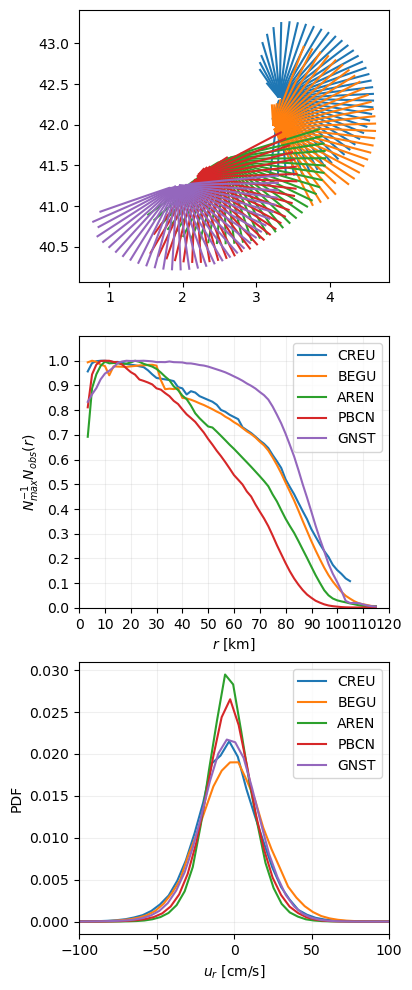

In [10]:
normalize_pdf = False
orientation = 'v'

# Create the plot

nplots = 3

if orientation == 'h':
    fig, ax = plt.subplots(1, nplots, figsize=(width * nplots, height))
else:
    fig, ax = plt.subplots(nplots, 1, figsize=(width, height * nplots))


for site in hfrsites:

    # Get the data
    
    nr = hfrdata[site].sizes['range']
    nb = hfrdata[site].sizes['bearing']

    ur = hfrdata[site].VELO.data
    flag = hfrdata[site].PRIM.data
    range = hfrdata[site].range.data
    lon = hfrdata[site].lon.data
    lat = hfrdata[site].lat.data
    nobs = hfrdata[site].nobs.sum(dim='time').astype(int)

    # Fill the map
    
    for i in np.arange(nb):
        index = nobs[:, i] > 1
        ax[0].plot(lon[index, i], lat[index, i], color=hfrcolors[site], label=site)

    # Fill the data distribution

    n = np.sum(nobs, axis=-1)
    ax[1].plot(range, n / np.max(n), color=hfrcolors[site], label=site)

    # Fill velocity PDFs

    if normalize_pdf:
        index = flag == 1
        aux = (ur[index] - np.mean(ur[index])) / np.std(ur[index])
        pdf, x = np.histogram(aux, density=True, bins=100)
        x = (np.roll(x, -1) + x)[:-1] / 2
        ax[2].semilogy(x, pdf, '.', color=hfrcolors[site], label=site)
    else:
        index = flag == 1
        pdf, x = np.histogram(ur[index], density=True, bins=50)
        x = (np.roll(x, -1) + x)[:-1] / 2
        ax[2].plot(x, pdf, color=hfrcolors[site], label=site)
        #ax[2].hist(ur[index], label=site, bins=200, range=[-150, 150], 
        #     alpha=0.5, density=True, color=hfrcolors[site])

# Properties of the n(r) plot

a = ax[1]
a.set_xlabel('$r$ [km]')
a.grid(True, alpha=0.2)
a.set_xticks(np.linspace(0, 120, num=13))
a.set_xlim(0, 120)
a.legend()
a.set_ylabel('$N_{max}^{-1}N_{obs}(r)$')
a.set_yticks(np.linspace(0, 1, num=11))
a.set_ylim(0, 1.1)

# Velocity PDF

a = ax[2]
if normalize_pdf:
    x = np.linspace(-10, 10, num=100)
    y = np.exp(- x ** 2 / 2) / np.sqrt(2 * np.pi)
    a.plot(x, y, 'k--')
    a.set_xlabel('$(u_r-\\langle u_r\\rangle)\\sigma_u^{-1}$')
    a.set_xlim(-10, 10)
    a.set_ylim(1e-6, 1)
else:
    a.set_xlabel('$u_r$ [cm/s]')
    a.set_xlim(-100, 100)
a.grid(True, alpha=0.2)
a.set_ylabel('PDF')
a.legend();

Plot an example of the data

2024-01-01T00:00:00.000000000


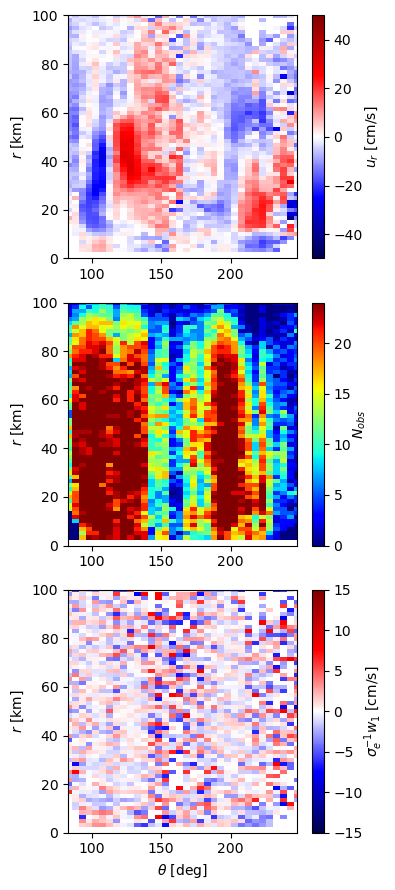

In [11]:
# Parameters

station = 'GNST'
orientation = 'v'
varlist = ['vel', 'num', 'w1']
i = 10

# Prepare the data

bearing = hfrdata_daily[station]['bearing'].data
range = hfrdata_daily[station]['range'].data
time = hfrdata_daily[station]['time'][i].data
nobs = hfrdata_daily[station]['nobs'][i, :, :].data
ur = hfrdata_daily[station]['VELO'][i, :, :].data

print(time)

# Compute noise. We do not use the noise compute before to ilustrate what happends if the number of
# observations are not taken into account

ur = np.ma.array(data=ur, mask=nobs < 1)
sigma, w1 = get_hfr_noise(ur, return_coeff=True)

# Compute the limits of the plot

count = np.sum(nobs, axis=0)
minb = np.min(bearing[count > 0])
maxb = np.max(bearing[count > 0])

# Create the plot

nplots = len(varlist)

if orientation == 'h':
    fig, ax = plt.subplots(1, nplots, figsize=(width * nplots, (height - 1)))
else:
    fig, ax = plt.subplots(nplots, 1, figsize=(width, (height - 1) * nplots))

for j, a in enumerate(ax):
    a.set_ylim(0, 100)
    a.set_xlim(minb, maxb)
    if (orientation == 'h' and j == 0) or orientation != 'h':
        a.set_ylabel('$r$ [km]')
    if (orientation != 'h' and j == nplots - 1) or orientation == 'h':
        a.set_xlabel('$\\theta$ [deg]')
        
# Plot the data

for j, varname in enumerate(varlist):
    if varname == 'vel':
        var = ur
        title = '$u_r$ [cm/s]'
        cmap = 'seismic'
        vmax = 50
        vmin = - vmax
    elif varname == 'num':
        var = nobs
        title = '$N_{obs}$'
        cmap = 'jet'
        vmin = 0
        vmax = 24
    elif varname == 'w1':
        var = np.squeeze(w1)
        title = '$\\sigma_e^{-1} w_1$ [cm/s]'
        cmap = 'seismic'
        vmin = - 15
        vmax = - vmin
    else:
        var = np.zeros((bearing.shape[0], range.shape[0]))
        title = 'unknown'
        cmap = None
        vmin = None
        vmax = None

    c = ax[j].pcolormesh(bearing, range, var, cmap=cmap, vmin=vmin, vmax=vmax)
    cb = fig.colorbar(c, ax=ax[j], label=title)
    cb.set_label(title, labelpad=0)

fig.tight_layout()
#fig.savefig('figures/fig_sample_measurement.pdf')

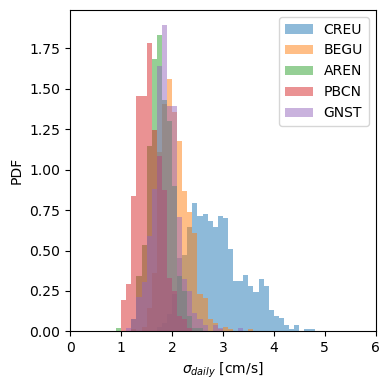

In [12]:
fig, ax = plt.subplots(figsize=(width, height))

for site in hfrsites:

    # Get the data
    
    sigma = hfrdata_daily[site]['sigma'].data

    # plot

    ax.hist(sigma, label=site, bins=150, range=[0, 15], 
             alpha=0.5, density=True, color=hfrcolors[site])

ax.legend()
ax.set_xlim(0, 6)
ax.set_xlabel('$\\sigma_{daily}$ [cm/s]')
ax.set_ylabel('PDF')
fig.tight_layout()
#fig.savefig('figures/fig_noise_pdf.pdf')

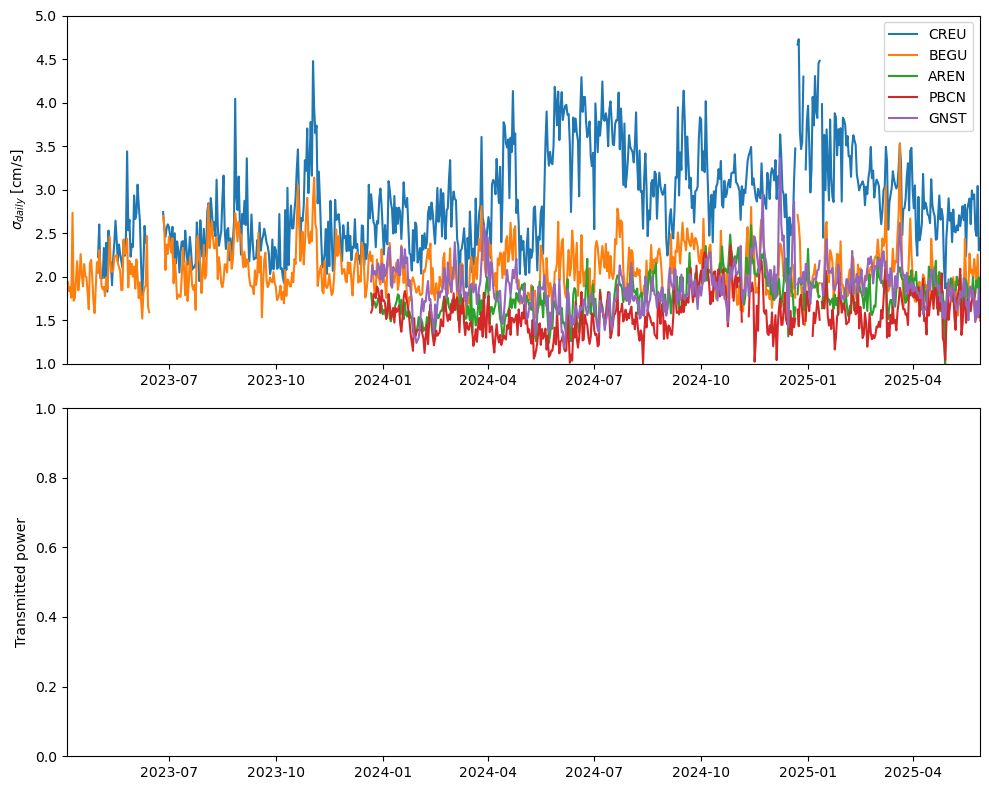

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10, 2 * height))

tmin = []
tmax = []

for site in hfrsites:

    # Get the data
    
    sigma = hfrdata_daily[site]['sigma'].data
    time = hfrdata_daily[site]['time'].data

    tmin.append(np.min(time))
    tmax.append(np.max(time))
    
    # Plot

    ax[0].plot(time, sigma, color=hfrcolors[site], label=site)

tmin = np.min(np.array(tmin))
tmax = np.max(np.array(tmax))

ax[0].legend()
ax[0].set_ylabel('$\\sigma_{daily}$ [cm/s]')
ax[0].set_ylim(1, 5)
ax[0].set_xlim(tmin, tmax)

ax[1].set_ylabel('Transmitted power')
ax[1].set_xlim(tmin, tmax)

fig.tight_layout()
#fig.savefig('figures/fig_noise_time_series.pdf')

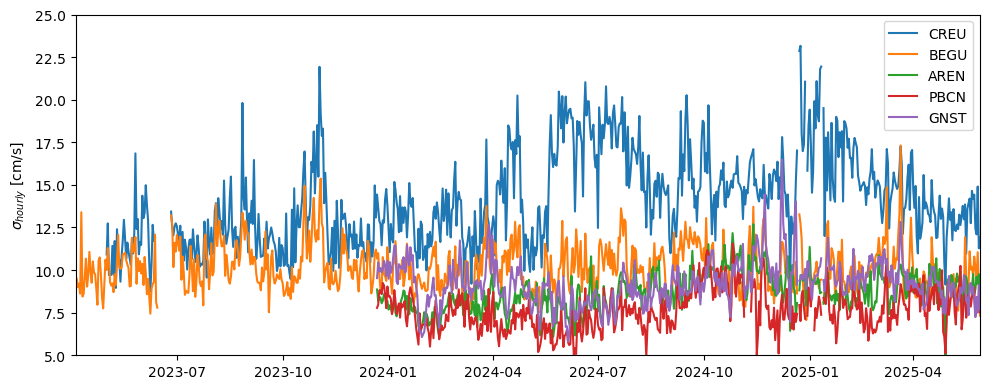

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, height))

tmin = []
tmax = []

for site in hfrsites:

    # Get the data
    
    sigma = hfrdata_daily[site]['sigma'].data
    time = hfrdata_daily[site]['time'].data

    tmin.append(np.min(time))
    tmax.append(np.max(time))
    
    # Plot

    ax.plot(time, np.sqrt(24) * sigma, color=hfrcolors[site], label=site)

tmin = np.min(np.array(tmin))
tmax = np.max(np.array(tmax))

ax.legend()
ax.set_ylabel('$\\sigma_{hourly}$ [cm/s]')
ax.set_ylim(5, 25)
ax.set_xlim(tmin, tmax)

fig.tight_layout()
#fig.savefig('figures/fig_noise_time_series.pdf')

In [15]:
pwd

'/Users/jisern/Recerca/Calculs/hfradar/tutorials'